In [1]:
# Imports
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset  # Gives easier dataset managment by creating mini batches etc.
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, f1_score, recall_score, precision_score, accuracy_score, confusion_matrix
from ViT_model import VisionTransformer

import sys
import cv2

import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import copy

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.has_mps:
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print("Device: {}".format(device))

Device: mps


In [3]:
#read the data 
#algorithm to read all the files

'''
for folder in this folder:
    read xelasensor1.csv
    read sliplabel.csv
    concat it in a single dataframe along axis = 0

print the dataframe
'''

directory = 'train2dof'
directory2 = '/Users/elijahnelson/Desktop/SIWES/IML/Tactile_IML/'

def read_file(detect_or_pred, n = None):

    #store all directories in a list
    list_xela_allfiles = []
    list_sliplabel_allfiles = []

    for root, subdirectories, files in os.walk(directory):
        for sdirectory in subdirectories:

            #subdirectory with absolute path
            subdirectory = '{}/{}'.format(root, sdirectory)

            #read specific files in the subdirectory
            for file in os.listdir(subdirectory):
            
                if not file.startswith(".") and file.endswith("sensor1.csv"):
                    df = pd.read_csv(f'{subdirectory}/{file}', index_col=None, header=0)
                    
                    if detect_or_pred ==0:
                        list_xela_allfiles.append(df)
                    elif detect_or_pred ==1 and n is not None:
                        list_xela_allfiles.append(df[:-n])

                if not file.startswith(".") and file.endswith("label.csv"):
                    df = pd.read_csv('{}/{}'.format(subdirectory, file), index_col=None, header=0)
                    if detect_or_pred ==0:
                        list_sliplabel_allfiles.append(df)
                    elif detect_or_pred ==1 and n is not None: 
                        list_sliplabel_allfiles.append(df[n:])

    return list_xela_allfiles, list_sliplabel_allfiles

    #np.newaxis; np.zeros (3,4,4) -> 
                    


In [4]:
#concat the list of xela_allfiles and sliplabel_allfiles across axis = 0
n = 0
# n = 5
list_xela_allfiles, list_sliplabel_allfiles = read_file(0)

#for slip prediction, comment the line above and uncomment the line below
# list_xela_allfiles, list_sliplabel_allfiles = read_file(1, n)

pd_xela_allfiles = pd.concat(list_xela_allfiles, axis=0, ignore_index=True)
pd_sliplabel_allfiles = pd.concat(list_sliplabel_allfiles, axis=0, ignore_index=True)
pd_sliplabel_allfiles = pd_sliplabel_allfiles['slip']

#reshape the target array into (rows, 1)
tac_label = pd_sliplabel_allfiles.values.reshape(pd_sliplabel_allfiles.shape[0], 1)


In [5]:
# pd_sliplabel_allfiles.to_csv('labels.csv')
pd_xela_allfiles.columns

Index(['txl1_x', 'txl1_y', 'txl1_z', 'txl2_x', 'txl2_y', 'txl2_z', 'txl3_x',
       'txl3_y', 'txl3_z', 'txl4_x', 'txl4_y', 'txl4_z', 'txl5_x', 'txl5_y',
       'txl5_z', 'txl6_x', 'txl6_y', 'txl6_z', 'txl7_x', 'txl7_y', 'txl7_z',
       'txl8_x', 'txl8_y', 'txl8_z', 'txl9_x', 'txl9_y', 'txl9_z', 'txl10_x',
       'txl10_y', 'txl10_z', 'txl11_x', 'txl11_y', 'txl11_z', 'txl12_x',
       'txl12_y', 'txl12_z', 'txl13_x', 'txl13_y', 'txl13_z', 'txl14_x',
       'txl14_y', 'txl14_z', 'txl15_x', 'txl15_y', 'txl15_z', 'txl16_x',
       'txl16_y', 'txl16_z'],
      dtype='object')

# RE-ARRANGEMENT OF TABULAR DATA INTO IMAGES

In [6]:
#arrange the data by 3, 4, 4

#arrange the columns by x, y, z
col_x = []
col_y = []
col_z = []

pd_columns = pd_xela_allfiles.columns
for col in pd_columns:
    if col.endswith('x'):
        col_x.append(col)
    
    elif col.endswith('y'):
        col_y.append(col)
    
    elif col.endswith('z'):
        col_z.append(col)

#arrange the table using the arranged columns
pd_xela_allfiles_x = pd_xela_allfiles[col_x]
pd_xela_allfiles_y = pd_xela_allfiles[col_y]
pd_xela_allfiles_z = pd_xela_allfiles[col_z]


#scale the data in the arranged columns
#scale the data of the features

sc = MinMaxScaler() #standard scaler
sc.fit(pd_xela_allfiles_x)
pd_xela_allfiles_x = sc.transform(pd_xela_allfiles_x)

sc.fit(pd_xela_allfiles_y)
pd_xela_allfiles_y = sc.transform(pd_xela_allfiles_y)

sc.fit(pd_xela_allfiles_z)
pd_xela_allfiles_z = sc.transform(pd_xela_allfiles_z)



#reshape the arranged data per row to (4,4) AND rotate 90 degree anti-clockwise and append to a list
pd_x = []
pd_y = []
pd_z = []

for row in range(len(pd_xela_allfiles_x)):
    pd_x.append(np.rot90(pd_xela_allfiles_x[row].reshape(4,4)))
    pd_y.append(np.rot90(pd_xela_allfiles_y[row].reshape(4,4)))
    pd_z.append(np.rot90(pd_xela_allfiles_z[row].reshape(4,4)))

#add all the x, y, z in a single list
pd_main = [pd_x, pd_y, pd_z]

#arrange pd_main in a 3, 4, 4 array where its 3(4, 4) of x, y, z values
pd_image = np.zeros( (pd_xela_allfiles.shape[0], 3, 4, 4))

#per row, get (4,4) of x, y, z and assign it to pd_image to form the image
for row in range(pd_xela_allfiles.shape[0]):
    x_4_4 = pd_main[0][row]
    y_4_4 = pd_main[1][row]
    z_4_4 = pd_main[2][row]

    pd_image[row][0] = x_4_4
    pd_image[row][1] = y_4_4
    pd_image[row][2] = z_4_4


In [7]:
# up_size = 224
# n_images = len(pd_x)
# tac_image = np.zeros((n_images, 3, up_size, up_size), np.float32) 
# for row in range(n_images):

#     #resize image to 3, up_size, up_size
#     for channel in range(3):
#         image_per_channel = pd_image[row][channel]
#         tac_image[row][channel] = cv2.resize(image_per_channel.astype(np.float32), dsize=(up_size, up_size), interpolation=cv2.INTER_CUBIC)
# pd_image = tac_image

In [8]:
pd_label = pd_sliplabel_allfiles.values.reshape(pd_sliplabel_allfiles.shape[0], 1)

torch.Size([229651, 3, 4, 4])


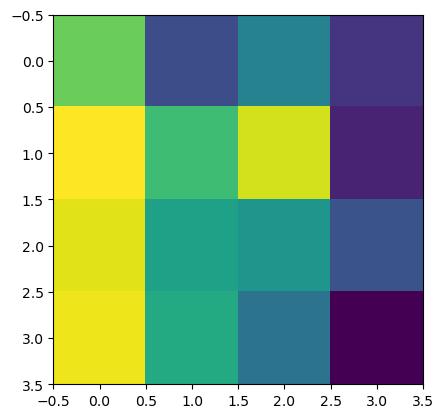

In [10]:
print(pd_image.shape)
plt.imshow(pd_image[0][1])
plt.show()

In [9]:
pd_image = torch.from_numpy(pd_image.astype(np.float32))
pd_label = torch.from_numpy(pd_label.astype(np.float32))

In [24]:
image_transform = transforms.Compose([
    transforms.Resize((224,224))
])

/Users/timii/miniconda3/envs/aienv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[[0.7834, 0.7834, 0.7834,  ..., 0.6412, 0.6412, 0.6412],
         [0.7834, 0.7834, 0.7834,  ..., 0.6412, 0.6412, 0.6412],
         [0.7834, 0.7834, 0.7834,  ..., 0.6412, 0.6412, 0.6412],
         ...,
         [0.7064, 0.7064, 0.7064,  ..., 0.4572, 0.4572, 0.4572],
         [0.7064, 0.7064, 0.7064,  ..., 0.4572, 0.4572, 0.4572],
         [0.7064, 0.7064, 0.7064,  ..., 0.4572, 0.4572, 0.4572]],

        [[0.6125, 0.6125, 0.6125,  ..., 0.2897, 0.2897, 0.2897],
         [0.6125, 0.6125, 0.6125,  ..., 0.2897, 0.2897, 0.2897],
         [0.6125, 0.6125, 0.6125,  ..., 0.2897, 0.2897, 0.2897],
         ...,
         [0.7159, 0.7159, 0.7159,  ..., 0.2103, 0.2103, 0.2103],
         [0.7159, 0.7159, 0.7159,  ..., 0.2103, 0.2103, 0.2103],
         [0.7159, 0.7159, 0.7159,  ..., 0.2103, 0.2103, 0.2103]],

        [[0.2512, 0.2512, 0.2512,  ..., 0.5122, 0.5122, 0.5122],
         [0.2512, 0.2512, 0.2512,  ..., 0.5122, 0.5122, 0.5122],
         [0.2512, 0.2512, 0.2512,  ..., 0.5122, 0.5122, 0.

In [13]:
pd_image_train, pd_image_test, pd_label_train, pd_label_test = train_test_split(pd_image, pd_label, test_size=0.1, shuffle=True)

#split into train and validation
pd_image_train, pd_image_valid, pd_label_train, pd_label_valid = train_test_split(pd_image_train, pd_label_train, test_size=0.3, shuffle = True)

In [14]:
pd_image_train.shape, pd_label_train.shape

(torch.Size([144679, 3, 4, 4]), torch.Size([144679, 1]))

In [15]:
class seq_dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return self.X.__len__()
    def __getitem__(self, index):
        return self.X[index].numpy(), self.y[index]

In [16]:
train_dataset = seq_dataset(pd_image_train, pd_label_train)
valid_dataset = seq_dataset(pd_image_valid, pd_label_valid)

train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=4096, shuffle=True, drop_last=True)

In [17]:
for i in train_loader:
    x_try = i[0]
    print(i[0].shape, i[1].shape)
    break

torch.Size([4096, 3, 4, 4]) torch.Size([4096, 1])


In [18]:
from transformers import AutoImageProcessor, ViTForImageClassification

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
ViT_model_class_1000 = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

In [19]:
class ViTModel(nn.Module):
    def __init__(self):
        super(ViTModel, self).__init__()
        self.ViT_model_class = ViT_model_class_1000
        self.linear = nn.Linear(1000, 1)
    def forward(self, x):
        x = self.ViT_model_class(x)
        x = self.linear(x[0])
        return x
    
model = ViTModel().to(device)

In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0]).to(device))
num_epochs = 300

In [23]:
#Training and validation loop 
train_loss = []
valid_loss = []

train_accuracy = []
valid_accuracy = []

t_loss = []
v_loss = []

t_acc = []
v_acc = []

for epoch in range(num_epochs):
    #Train per batch
    train_loss = []
    valid_loss = []
    train_accuracy = []
    valid_accuracy = []

    model.train()
    for (x, y) in (train_loader):
        #Forward pass
        y_pred = model(x.to(device))
        #compute the loss
        l = criterion(y_pred.to(device), y.to(device))
        #empty the gradients
        optimizer.zero_grad()
        #compute the gradient
        l.backward()
        #update the weights
        optimizer.step()
        #append each loss per batch
        train_loss.append(l.item())
        train_accuracy.append(accuracy_score(y.detach().cpu().numpy().round(), y_pred.detach().cpu().numpy().round()))
        
    

    #calculate and plot the validation loss
    model.eval()
    with torch.no_grad():
        for (x,y) in (valid_loader):
            y_pred = model(x.to(device))
            lv = criterion(y_pred.to(device), y.to(device))
            #append the loss per batch
            valid_loss.append(lv.item())
            #accuracy
            valid_accuracy.append(accuracy_score(y.detach().cpu().numpy().round(), y_pred.detach().cpu().numpy().round()))

    #append the total loss and accuracy per epoch
    t_loss.append(np.mean(train_loss))
    v_loss.append(np.mean(valid_loss))
    t_acc.append(np.mean(train_accuracy))
    v_acc.append(np.mean(valid_accuracy))

    print(f'Epoch {epoch+1}, loss = {np.mean(train_loss):.4f} , val_loss = {np.mean(valid_loss):.4f}')
    torch.save(model.state_dict(), 'ViT_checkpoint.pth')

SyntaxError: cannot assign to function call (1418485841.py, line 22)

In [ ]:
torch.save(model.state_dict(), f'ViT_n{n}.pth')

In [ ]:
def plot(metric, title):
    plt.plot(metric)
    plt.title(title)
    plt.show() 

In [ ]:
plot(t_loss, "Train Loss")
plot(v_loss, "Val Loss")

plot(t_acc, "Train Accuracy")
plot(v_acc, "Val Accuracy")